In [1]:
import os
cwd = os.getcwd()
os.chdir(os.path.join(cwd,'../../..'))

In [2]:
import ExMAS.utils
import ExMAS.main
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from ExMAS.utils import inData as inData

In [3]:
params = ExMAS.utils.get_config('ExMAS/data/configs/ams-config-1.json') # load the default 
params.nP= 600
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph
inData = ExMAS.utils.load_albatross_csv(inData, params, sample=True)


In [4]:
inData = ExMAS.main(inData, params, plot = False)


28-04-21 11:57:12-INFO-Initializing pairwise trip shareability between 600 and 600 trips.
28-04-21 11:57:12-INFO-creating combinations
28-04-21 11:57:13-INFO-359400	 nR*(nR-1)
28-04-21 11:57:23-INFO-Reduction of feasible pairs by 99.62%
28-04-21 11:57:23-INFO-Degree 2 	Completed
28-04-21 11:57:23-INFO-trips to extend at degree 2 : 2733
28-04-21 11:57:27-INFO-At degree 2 feasible extensions found out of 455 searched
28-04-21 11:57:27-INFO-Degree 3 	Completed
28-04-21 11:57:27-INFO-trips to extend at degree 3 : 455
28-04-21 11:57:27-INFO-At degree 3 feasible extensions found out of 31 searched
28-04-21 11:57:27-INFO-Degree 4 	Completed
28-04-21 11:57:27-INFO-trips to extend at degree 4 : 31
28-04-21 11:57:27-INFO-At degree 4 feasible extensions found out of 0 searched
28-04-21 11:57:27-INFO-Degree 5 	Completed
28-04-21 11:57:27-INFO-No more trips to exted at degree 5
28-04-21 11:57:33-INFO-Matching 600 trips to 3819 rides in order to minimize u_veh
28-04-21 11:57:35-INFO-Problem solution

In [5]:
walk_speed = 1.389                     #m/s
walk_time  = 5                         #min
walk_dist  = round (walk_speed*60*5)   #metres

In [6]:
def pudo_requests(_inData, walk_speed = 1.389, walk_time = 5):
    
    walk_dist = round(walk_speed*60*5)
    
    pudo = pd.DataFrame(index = range(len(_inData.sblts.requests)), columns = ['pax_id', 'origin', 'destination', \
                               'origin_nodes','destination_nodes','origin_dist','destination_dist'])
    pudo['pax_id'] = _inData.sblts.requests['index']
    pudo['origin'] = _inData.sblts.requests['origin'].tolist()
    pudo['destination'] = _inData.sblts.requests['destination'].tolist()
    pudo = pudo.astype(object)
    for i in range(len(pudo)):
        #origins = _inData.skim[pudo.iloc[i]['origin']][(_inData.skim[pudo.iloc[i]['origin']]<walk_dist) & (_inData.skim[pudo.iloc[i]['origin']]>0)].sort_values()                 #excludes original origin as PUDO point
        origins = _inData.skim[pudo.iloc[i]['origin']][(_inData.skim[pudo.iloc[i]['origin']]<walk_dist)].sort_values()                                                             # everything in walk_dist radius
        
        #destinations = _inData.skim[pudo.iloc[i]['destination']][(_inData.skim[pudo.iloc[i]['destination']]<walk_dist) & _inData.skim[pudo.iloc[i]['destination']]>0].sort_values()
        destinations = _inData.skim[pudo.iloc[i]['destination']][(_inData.skim[pudo.iloc[i]['destination']]<walk_dist)].sort_values()
        
        pudo.at[i,'origin_nodes'] = list(origins.index)
        pudo.at[i,'destination_nodes'] = list(destinations.index)
        
        pudo.at[i,'origin_dist']  = origins.tolist()
        pudo.at[i,'destination_dist'] = destinations.tolist()
        
    _inData.pudo = pudo
    
    return _inData


In [7]:
  
def plot_map_rides(inData, ride_indexes, light=True, m_size=30, lw=3, fontsize = 10, figsize = (40,40)):
    import seaborn as sns

    from matplotlib.collections import LineCollection

    def make_schedule(t, r, p):
        columns = ['node', 'times', 'req_id','pudo_nodes', 'od']
        degree = 2 * len(t.indexes)
        df = pd.DataFrame(None, index=range(degree), columns=columns)
        x = t.indexes_orig
        s = [r.loc[i].origin for i in x] + [r.loc[i].destination for i in x]
        p = [p.iloc[i].origin_nodes for i in x] + [p.iloc[i].destination_nodes for i in x]      #retrieving pudo locs from PUDO DF
        df.node = pd.Series(s)                                                                                    # adding pudo to DF
        df.pudo_nodes = pd.Series(p)
        df.req_id = x + t.indexes_dest
        df.times = t.times
        df.od = pd.Series(['o'] * len(t.indexes) + ['d'] * len(t.indexes))
        return df


    def add_route(ax, route, color='grey', lw=2, alpha=0.5):
        # plots route on the graph alrready plotted on ax
        edge_nodes = list(zip(route[:-1], route[1:]))
        lines = []
        for u, v in edge_nodes:
            # if there are parallel edges, select the shortest in length
            data = min(G.get_edge_data(u, v).values(), key=lambda x: x['length'])
            # if it has a geometry attribute (ie, a list of line segments)
            if 'geometry' in data:
                # add them to the list of lines to plot
                xs, ys = data['geometry'].xy
                lines.append(list(zip(xs, ys)))
            else:
                # if it doesn't have a geometry attribute, the edge is a straight
                # line from node to node
                x1 = G.nodes[u]['x']
                y1 = G.nodes[u]['y']
                x2 = G.nodes[v]['x']
                y2 = G.nodes[v]['y']
                line = [(x1, y1), (x2, y2)]
                lines.append(line)
        lc = LineCollection(lines, colors=color, linewidths=lw, alpha=alpha, zorder=3)
        ax.add_collection(lc)

    s = inData.sblts.rides
    r = inData.sblts.requests
    G = inData.G
    p  = inData.pudo
    ts = [make_schedule(s.iloc[ride_index],r,p) for ride_index in ride_indexes]

    # t1 = make_schedule(s.iloc[1], r)
    # t2 = make_schedule(s[s.kind == 20].iloc[1], r)
    #t3 = make_schedule(s[s.kind == 31].iloc[3], r)



    G = inData.G
    fig, ax = ox.plot_graph(G, figsize=figsize, node_size=0, edge_linewidth=0.3,
                            show=False, close=False,
                            edge_color='grey',  bgcolor='white')

    #colors = {1: 'navy', 2: 'teal', 3: 'maroon', 4: 'black', 5: 'green', 6:'teal'}
    colors = sns.color_palette("Set2",6)


    for t in ts:

        orig_points_lats, orig_points_lons, dest_points_lats, dest_points_lons = [], [], [], []
        deg = t.req_id.nunique()
        count = 0
        for i in t.req_id.unique():
            count += 1
            r = t[t.req_id == i]

            o = r[r.od == 'o'].iloc[0].node
            d = r[r.od == 'd'].iloc[0].node
            
            o_pudo = r[r.od == 'o'].iloc[0].pudo_nodes
            d_pudo = r[r.od == 'd'].iloc[0].pudo_nodes

            if not light:
                ax.annotate('o' + str(i), (G.nodes[o]['x'] * 1.0001, G.nodes[o]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
                ax.annotate('d' + str(i), (G.nodes[d]['x'] * 1.0001, G.nodes[d]['y'] * 1.00001), fontsize = fontsize,
                    bbox = dict(facecolor='white', alpha=0.7, edgecolor='none'))
            route = nx.shortest_path(G, o, d, weight='length')
            add_route(ax, route, color='black', lw=lw / 2, alpha=0.3)
            ax.scatter(G.nodes[o]['x'], G.nodes[o]['y'], s=m_size, c=[colors[deg]], marker='o')
            ax.scatter(G.nodes[d]['x'], G.nodes[d]['y'], s=m_size, c=[colors[deg]], marker='>')
            for o_p in o_pudo:
                ax.scatter(G.nodes[o_p]['x'], G.nodes[o_p]['y'], s=m_size,alpha = 1, c=[colors[deg]], marker='x')
            for d_p in d_pudo:
                ax.scatter(G.nodes[d_p]['x'], G.nodes[d_p]['y'], s=m_size,alpha = 1, c=[colors[deg]], marker='x')
        routes = list()  # ride segments
        o = t.node.values[0]
        for d in t.node.values[1:]:
            routes.append(nx.shortest_path(G, o, d, weight='length'))
            o = d
        for route in routes:
            add_route(ax, route, color=[colors[deg]], lw=lw, alpha=0.7)
    plt.tight_layout()
    plt.savefig('map.png', dpi = 300)

In [8]:
def ride_to_pudo_graph(ride):                                                    # function converts skim of PUDO locations between requests to a dictionary. 
    
    graph = {}                                                                   # The skim of two requests is saved in graph, ordered as indexes_origin + indexes_destination
    for i,trip_o in enumerate(ride.indexes):
        #O_0 = inData.pudo.iloc[r.indexes[0]].origin
        if i<(len(r.indexes)-1):
            O_0 = inData.pudo.iloc[ride.indexes[i]].origin_nodes
            O_1 = inData.pudo.iloc[ride.indexes[i+1]].origin_nodes

            D_0 = inData.pudo.iloc[ride.indexes_dest[i]].destination_nodes
            D_1 = inData.pudo.iloc[ride.indexes_dest[i+1]].destination_nodes
            graph[i]  = inData.skim.loc[O_0][O_1]

            graph[i+(len(r.indexes))] = inData.skim.loc[D_0][D_1]
        else:
            O_0 = inData.pudo.iloc[ride.indexes[-1]].origin_nodes
            D_0 = inData.pudo.iloc[ride.indexes_dest[0]].destination_nodes
            graph[i]  = inData.skim.loc[O_0][D_0]
    for i,g in enumerate(graph):
        graph[i] = graph[i].stack().sort_values()                              # sort skim distances from least to greatest
        
    return graph                                                               # Size of graph indeces is (len(indexes_origin + indexes_destination) -1)

# Three trips

Sort of a brutte search algorithm, a few break commands are inserted to speed up the process. The amount of for loops are equivalent to the number of skims in 'graph', for rides with degree==3 that is 5 loops, rides with degree == 4 is 7 loops, and so on. 

Further optimisation is required though, for rides with larger degree, the search time increases exponentially.

EDIT: Introduced 'counter' speeds up the optimisation heavily. 

In [115]:
def three_degree_pudo(_graph):
    
    distances   = [0]*(len((r.indexes))+(len(r.indexes)-1))                                                 #Empty list to store distances between nodes, will constantly be overwritten
    nodes       = [0] *(len(r.indexes)*2)                                                                   #Empty list to store the optimal PUDO locations

    predecessor = [float('inf')]                                                                            #Stores the theoretical minium
    counter     = 0
    limit       = 100                                                                                       #Iteration limit
    for i, d_0 in enumerate(_graph[0]):    
        if counter >= limit:
            break        
        dist_0  = d_0            
        nodes_0 = _graph[0].where(_graph[0]==dist_0).dropna(how='all').head(n=1)                            # Find PUDO nodes respective to dist_i
        distances[0]=dist_0                                                                                 # Assign distance to list
        if sum(predecessor)< sum(distances):                                                                # break loop if first distance is somehow longer than all distances combined
            break

        for j, d_1 in enumerate(_graph[1].loc[nodes_0.index[0][1]]):
            if counter >= limit:
                break
            dist_1  = _graph[1].loc[nodes_0.index[0][1]].iloc[j]                                            # distance wrt to selected 'destination' node from previous loop
            nodes_1 = _graph[1].where(_graph[1]==dist_1).dropna(how='all').head(n=1)
            distances[1]=dist_1

            if sum(predecessor)< sum(distances) or abs(sum(predecessor)-sum(distances))<=1500:              # break loop if first distance is somehow longer than all distances combined or differences less than 1500m
                distances[1] = 0                                                                            # reset specific distance to 0
                counter = counter + 1                                                                       # record iteration
                break

            for k, d_2 in enumerate(_graph[2].loc[nodes_1.index[0][1]]):
                if counter >= limit:
                    break
                dist_2 = _graph[2].loc[nodes_1.index[0][1]].iloc[k]
                nodes_2 = _graph[2].where(_graph[2]==dist_2).dropna(how='all').head(n=1)
                distances[2]=dist_2

                if sum(predecessor)< sum(distances):
                    distances[2] = 0
                    counter = counter + 1
                    break

                for l, d_3 in enumerate(_graph[3].loc[nodes_2.index[0][1]]):
                    if counter >= limit:
                        break                    
                    dist_3  = _graph[3].loc[nodes_2.index[0][1]].iloc[l]
                    nodes_3 = _graph[3].where(_graph[3]==dist_3).dropna(how='all').head(n=1)
                    distances[3]=dist_3

                    if sum(predecessor)< sum(distances):
                        distances[3] = 0
                        counter = counter + 1
                        break

                    for m, d_4 in enumerate(_graph[4].loc[nodes_3.index[0][1]]):
                        dist_4 = _graph[4].loc[nodes_3.index[0][1]].iloc[m]
                        nodes_4 = _graph[4].where(_graph[4]==dist_4).dropna(how='all').head(n=1)
                        distances[4]=dist_4
                        #print(sum(distances), sum(predecessor),counter)
                        if i == j == k == l == m == 0:                                                         # for first iteration, make sure total distance is saved
                            predecessor = distances.copy()
                            #print(predecessor)
                        elif sum(predecessor)< sum(distances):                                                 # eventually previous is compared to newly saved distance, if predecessor is still smaller, loop breaks
                            distances[4] = 0
                            counter = counter + 1
                            break    
                        elif sum(predecessor)> sum(distances):                                                # if distances are smaller than predecessor, copy distances to predecessor and save nodes
                            predecessor = distances.copy()
                            distances[4] = 0
                            counter = counter + 1
                            nodes[0]    = nodes_0.index[0][0]
                            nodes[1]    = nodes_0.index[0][1]
                            nodes[2]    = nodes_1.index[0][1]
                            nodes[3]    = nodes_2.index[0][1]
                            nodes[4]    = nodes_3.index[0][1]
                            nodes[5]    = nodes_4.index[0][1]
                            break
                            
    ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))

    return ttimes , nodes

# Four Trips

Pretty much the same as the code for three trips but with a couple of more for loops


In [130]:
def four_degree_pudo(_graph):
    distances   = [0]*(len((r.indexes))*2-1)
    nodes       = [0] *(len(r.indexes)*2)

    predecessor = [float('inf')]
    
    counter     = 0
    limit       = 1000

    for i, d_0 in enumerate(_graph[0]):
        if counter >= limit:
            break
        dist_0  = d_0
        nodes_0 = _graph[0].where(_graph[0]==dist_0).dropna(how='all').head(n=1)
        distances[0]=dist_0
        if sum(predecessor)< sum(distances):
            break    
        for j, d_1 in enumerate(_graph[1].loc[nodes_0.index[0][1]]):
            if counter >= limit:
                break              
            dist_1  = _graph[1].loc[nodes_0.index[0][1]].iloc[j]
            nodes_1 = _graph[1].where(_graph[1]==dist_1).dropna(how='all').head(n=1)
            distances[1]=dist_1

            if sum(predecessor)< sum(distances):
                distances[1] = 0
                counter = counter + 1
                break
  
            
            for k, d_2 in enumerate(_graph[2].loc[nodes_1.index[0][1]]):
                if counter >= limit:
                    break
                dist_2 = _graph[2].loc[nodes_1.index[0][1]].iloc[k]
                nodes_2 = _graph[2].where(_graph[2]==dist_2).dropna(how='all').head(n=1)
                distances[2]=dist_2
                if sum(predecessor)< sum(distances):
                    distances[2] = 0
                    counter = counter + 1
                    break    

                    
                for l, d_3 in enumerate(_graph[3].loc[nodes_2.index[0][1]]):
                    if counter >= limit:
                        break         
                    dist_3  = _graph[3].loc[nodes_2.index[0][1]].iloc[l]
                    nodes_3 = _graph[3].where(_graph[3]==dist_3).dropna(how='all').head(n=1)
                    distances[3]=dist_3
                    if sum(predecessor)< sum(distances):
                        distances[3] = 0
                        counter = counter + 1
                        break
   
                        
                    for m, d_4 in enumerate(_graph[4].loc[nodes_3.index[0][1]]):
                        if counter >= limit:
                            break 
                        dist_4 = _graph[4].loc[nodes_3.index[0][1]].iloc[m]
                        nodes_4 = _graph[4].where(_graph[4]==dist_4).dropna(how='all').head(n=1)
                        distances[4]=dist_4
                        if sum(predecessor)< sum(distances):
                            distances[4] = 0
                            counter = counter + 1
                            break   
 
                        for n, d_5 in enumerate(_graph[5].loc[nodes_4.index[0][1]]):
                            if counter >= limit:
                                break                               
                            dist_5 = _graph[5].loc[nodes_4.index[0][1]].iloc[n]
                            nodes_5 = _graph[5].where(_graph[5]==dist_5).dropna(how='all').head(n=1)
                            distances[5]=dist_5
                            if sum(predecessor)< sum(distances):
                                distances[5] = 0
                                counter = counter + 1
                                break       
                                
                            for o, d_6 in enumerate(_graph[6].loc[nodes_5.index[0][1]]):
                                dist_6 = _graph[6].loc[nodes_5.index[0][1]].iloc[o]
                                nodes_6 = _graph[6].where(_graph[6]==dist_6).dropna(how='all').head(n=1)
                                distances[6]=dist_6
                                #print(sum(distances), sum(predecessor),counter)
                                if i == j == k == l == m == n == o == 0:
                                    predecessor = distances.copy()
                                    #print(predecessor)
                                if sum(predecessor)< sum(distances):
                                    distances[6] = 0
                                    counter = counter + 1
                                    break    
                                elif sum(predecessor)> sum(distances):  
                                    predecessor = distances.copy()
                                    distances[6] = 0
                                    counter = counter + 1
                                    nodes[0]    = nodes_0.index[0][0]
                                    nodes[1]    = nodes_0.index[0][1]
                                    nodes[2]    = nodes_1.index[0][1]
                                    nodes[3]    = nodes_2.index[0][1]
                                    nodes[4]    = nodes_3.index[0][1]
                                    nodes[5]    = nodes_4.index[0][1]
                                    nodes[6]    = nodes_5.index[0][1]
                                    nodes[7]    = nodes_6.index[0][1]
                                    break
                                    
    ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))

    return ttimes , nodes

# Five Trips

In [131]:
def five_degree_pudo(_graph):
    distances   = [0]*(len((r.indexes))*2-1)
    nodes       = [0] *(len(r.indexes)*2)

    predecessor = [float('inf')]

    counter = 0
    limit   = 1000
    for i, d_0 in enumerate(_graph[0]):
        if counter >= limit:
            break        
        dist_0  = d_0
        nodes_0 = _graph[0].where(_graph[0]==dist_0).dropna(how='all').head(n=1)
        distances[0]=dist_0
        if sum(predecessor)< sum(distances):
            break
            
        for j, d_1 in enumerate(_graph[1].loc[nodes_0.index[0][1]]):
            if counter >= limit:
                break            
            dist_1  = _graph[1].loc[nodes_0.index[0][1]].iloc[j]
            nodes_1 = _graph[1].where(_graph[1]==dist_1).dropna(how='all').head(n=1)
            distances[1]=dist_1
            if sum(predecessor)< sum(distances):
                distances[1] = 0
                counter = counter +1
                break

                
            for k, d_2 in enumerate(_graph[2].loc[nodes_1.index[0][1]]):
                if counter >= limit:
                    break
                dist_2 = _graph[2].loc[nodes_1.index[0][1]].iloc[k]
                nodes_2 = _graph[2].where(_graph[2]==dist_2).dropna(how='all').head(n=1)
                distances[2]=dist_2
                if sum(predecessor)< sum(distances):
                    distances[2] = 0
                    counter = counter +1
                    break                    
                for l, d_3 in enumerate(_graph[3].loc[nodes_2.index[0][1]]):
                    if counter >= limit:
                        break
                    dist_3  = _graph[3].loc[nodes_2.index[0][1]].iloc[l]
                    nodes_3 = _graph[3].where(_graph[3]==dist_3).dropna(how='all').head(n=1)
                    distances[3]=dist_3

                    if sum(predecessor)< sum(distances):
                        distances[3] = 0
                        counter = counter +1
                        break

                        
                    for m, d_4 in enumerate(_graph[4].loc[nodes_3.index[0][1]]):
                        if counter >= limit:
                            break
                        dist_4 = _graph[4].loc[nodes_3.index[0][1]].iloc[m]
                        nodes_4 = _graph[4].where(_graph[4]==dist_4).dropna(how='all').head(n=1)
                        distances[4]=dist_4
                        #print(sum(distances), sum(predecessor))
                        if sum(predecessor)< sum(distances):
                            distances[4] = 0
                            counter = counter +1
                            break 

                        
                        for n, d_5 in enumerate(_graph[5].loc[nodes_4.index[0][1]]):
                            if counter >= limit:
                                break
                            dist_5 = _graph[5].loc[nodes_4.index[0][1]].iloc[m]
                            nodes_5 = _graph[5].where(_graph[5]==dist_5).dropna(how='all').head(n=1)
                            distances[5]=dist_5
                            if sum(predecessor)< sum(distances):
                                distances[5] = 0
                                counter = counter +1
                                break  
                                
                            for o, d_6 in enumerate(_graph[6].loc[nodes_5.index[0][1]]):
                                if counter >= limit:
                                    break
                                dist_6 = _graph[6].loc[nodes_5.index[0][1]].iloc[o]
                                nodes_6 = _graph[6].where(_graph[6]==dist_6).dropna(how='all').head(n=1)
                                distances[6]=dist_6
                                #print(sum(distances), sum(predecessor),counter)
                                if sum(predecessor)< sum(distances):
                                    distances[6] = 0
                                    counter = counter +1
                                    break 


                                for p, d_7 in enumerate(_graph[7].loc[nodes_6.index[0][1]]):
                                    if counter >= limit:
                                        break
                                    dist_7 = _graph[7].loc[nodes_6.index[0][1]].iloc[p]
                                    nodes_7 = _graph[7].where(_graph[7]==dist_7).dropna(how='all').head(n=1)
                                    distances[7]=dist_7
                                    if sum(predecessor)< sum(distances):
                                        distances[7] = 0
                                        counter = counter + 1
                                        break  


                                    for q, d_8 in enumerate(_graph[8].loc[nodes_7.index[0][1]]):
                                        dist_8 = _graph[8].loc[nodes_7.index[0][1]].iloc[q]
                                        nodes_8 = _graph[8].where(_graph[8]==dist_8).dropna(how='all').head(n=1)
                                        distances[8]=dist_8     
                                        #print(sum(distances), sum(predecessor),counter)
                                        if i == j == k == l == m == n == o == p == q ==  0:
                                            predecessor = distances.copy()
                                        elif sum(predecessor)< sum(distances):
                                            distances[8] = 0
                                            counter = counter + 1
                                            break    
                                        elif sum(predecessor)>= sum(distances):  
                                            predecessor = distances.copy()
                                            distances[8] = 0
                                            counter = counter + 1
                                            nodes[0]    = nodes_0.index[0][0]
                                            nodes[1]    = nodes_0.index[0][1]
                                            nodes[2]    = nodes_1.index[0][1]
                                            nodes[3]    = nodes_2.index[0][1]
                                            nodes[4]    = nodes_3.index[0][1]
                                            nodes[5]    = nodes_4.index[0][1]
                                            nodes[6]    = nodes_5.index[0][1]
                                            nodes[7]    = nodes_6.index[0][1]
                                            nodes[8]    = nodes_7.index[0][1]
                                            nodes[9]    = nodes_8.index[0][1]
                                            break

    ttimes = list(map(lambda x: round(x/params.avg_speed), predecessor))

    return ttimes , nodes

In [12]:
inData = pudo_requests(inData)

# Testing

A specific ride is selected for optimisation, this specific ride is also visualised with respective PUDO points

In [33]:
r = inData.sblts.rides[inData.sblts.rides.degree!=1]
r = r[r.degree!=2]
r = r[r.selected == 1]

                                                       #last feasbile shared ride selected
r = r.iloc[-2]
r

indexes                                         [153, 193, 209, 265]
u_pax                                                        42.1844
u_veh                                                           1612
kind                                                              40
u_paxes            [17.894975000000002, 11.501175, 6.875925, 5.91...
times                       [991.5, 252, 495, 359, 33, 141, 282, 50]
indexes_orig                                    [153, 193, 209, 265]
indexes_dest                                    [193, 209, 153, 265]
degree                                                           NaN
index                                                           3809
lambda_r                                                    0.430389
PassHourTrav_ns                                                 2830
row                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
selected                                                           1
Name: 3809, dtype: object

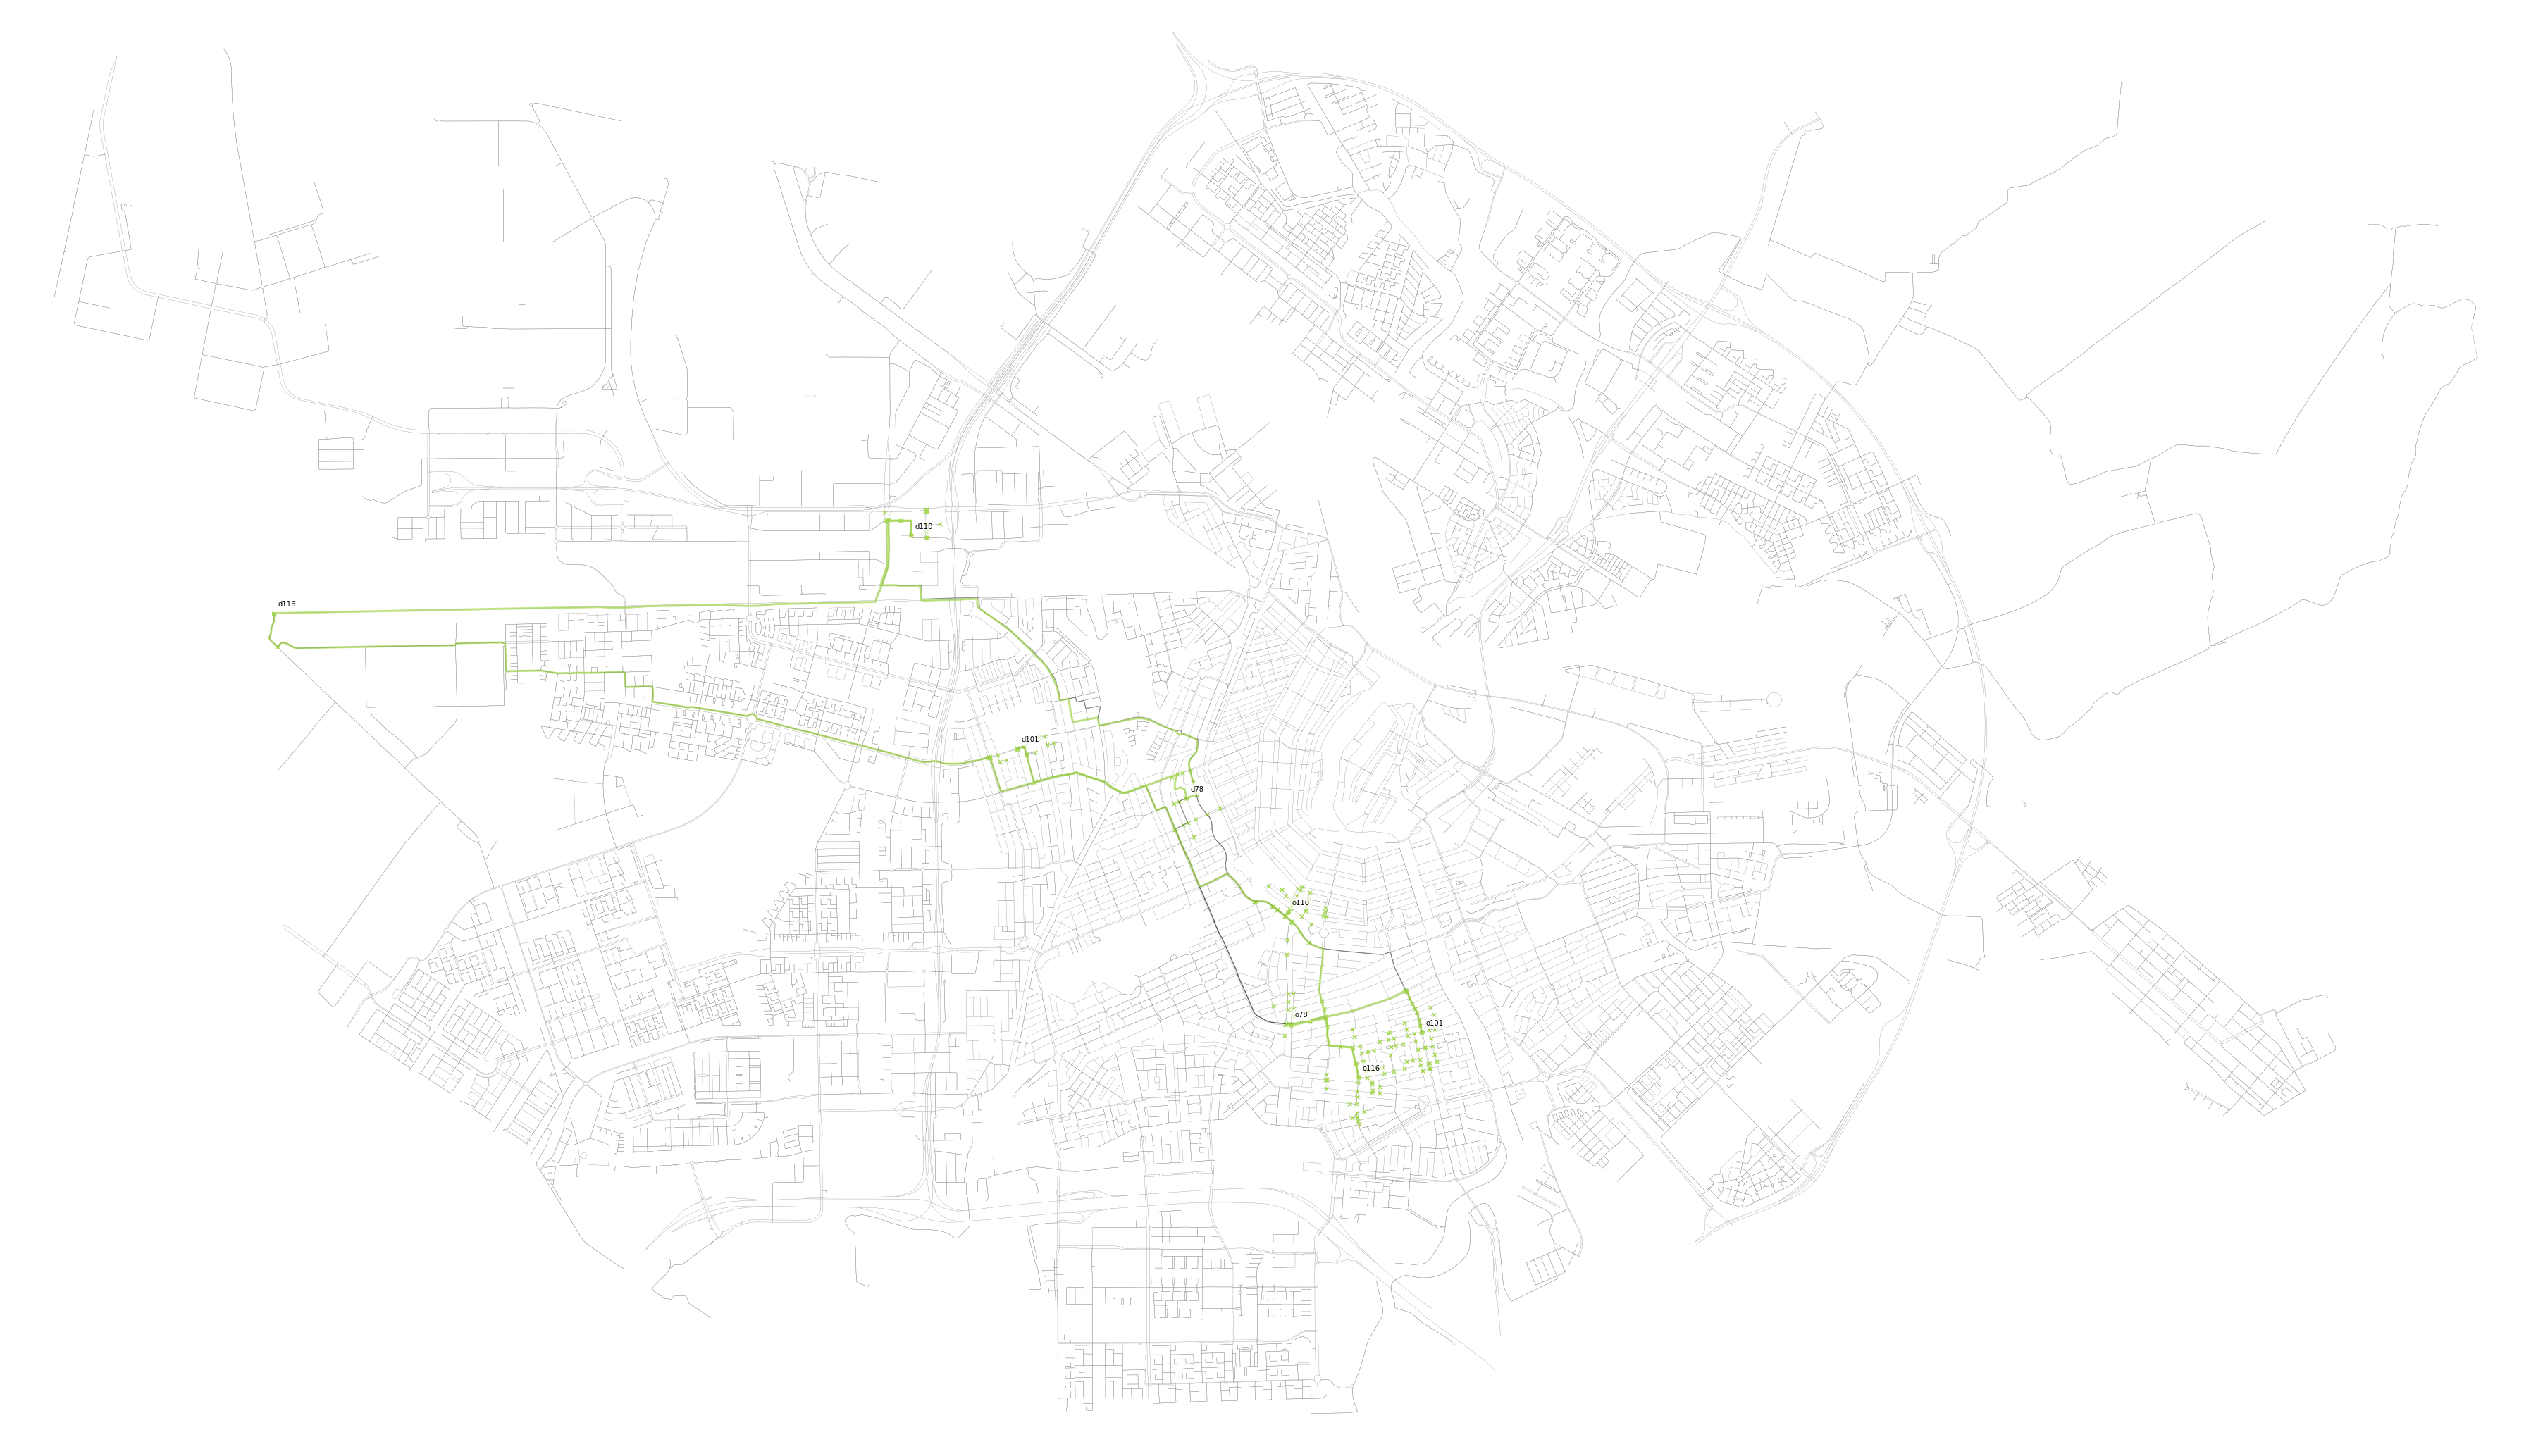

In [134]:
plot_map_rides(inData, [r['index']], light=False, m_size=30, lw=3, fontsize = 10, figsize = (50,50))

In [125]:
graph = ride_to_pudo_graph(r)
# specific function assigned to specific ride degree
if len(r.indexes)==3:                      
    a = three_degree_pudo(graph)

elif len(r.indexes)==4:
    a = four_degree_pudo(graph)
    
elif len(r.indexes)==5:
    a = five_degree_pudo(graph)

# All selected rides

PUDO optimisation takes place on all selected rides with degrees of three and higher, result is a large dataframe

In [132]:
df = pd.DataFrame(columns =['index','indexes','u_veh','u_veh_pudo','times','indexes_orig','PUDO_orig','indexes_dest','PUDO_dest','PassHourTrav_ns','degree'])

rides = inData.sblts.rides[inData.sblts.rides.degree!=1]
rides = rides[rides.degree!=2]
rides = rides[rides.selected == 1]

for index,r in rides.iterrows():
    graph = ride_to_pudo_graph(r)
    if len(r.indexes)==3:
        a = three_degree_pudo(graph)
    elif len(r.indexes)==4:
        a = four_degree_pudo(graph)
    elif len(r.indexes)==5:
        a = five_degree_pudo(graph)
    
    tt_i= a[0]
    tt = sum(a[0])
    pudo_nodes= a[1]
    pu_nodes  = pudo_nodes[:len(pudo_nodes)//2]
    do_nodes  = pudo_nodes[len(pudo_nodes)//2:]

    d = {'index':r['index'],
        'indexes': r.indexes,
        'u_veh':r.u_veh,
         'u_veh_pudo':tt,
        'times':tt_i,
        'indexes_orig':r.indexes_orig,
        'PUDO_orig':pu_nodes,
        'indexes_dest':r.indexes_dest,
        'PUDO_dest':do_nodes,
        'PassHourTrav_ns':int(tt),
        'degree':len(r.indexes)}

    df = df.append(d,ignore_index=True)
df = df.set_index('index')

In [133]:
df

,indexes,u_veh,u_veh_pudo,times,indexes_orig,PUDO_orig,indexes_dest,PUDO_dest,PassHourTrav_ns,degree
index,,,,,,,,,,
3340,"[77, 39, 102]",1094,780,"[21, 20, 264, 138, 337]","[77, 39, 102]","[46297764, 284742286, 3295383145]","[102, 77, 39]","[46324030, 7191839618, 6208433356]",780,3
3348,"[310, 301, 291]",1713,1406,"[0, 39, 615, 407, 345]","[310, 301, 291]","[1351319048, 1351319048, 46261260]","[310, 291, 301]","[46316298, 6235704568, 46285267]",1406,3
3350,"[296, 278, 336]",1312,1005,"[217, 211, 180, 124, 273]","[296, 278, 336]","[46484989, 46463438, 46402405]","[336, 296, 278]","[722976543, 46345942, 1686005082]",1005,3
3375,"[225, 328, 256]",2962,2475,"[174, 357, 1158, 642, 144]","[225, 328, 256]","[0, 0, 0]","[256, 225, 328]","[0, 0, 0]",2475,3
3396,"[369, 374, 573]",1577,1347,"[219, 471, 0, 180, 477]","[369, 374, 573]","[0, 0, 0]","[369, 374, 573]","[0, 0, 0]",1347,3
3401,"[321, 351, 350]",1344,1105,"[93, 0, 342, 106, 564]","[321, 351, 350]","[46289809, 46300548, 46304169]","[321, 351, 350]","[2020569044, 561326603, 46436940]",1105,3
3402,"[72, 100, 106]",784,626,"[0, 104, 25, 405, 92]","[72, 100, 106]","[46351186, 46351186, 1383265901]","[106, 72, 100]","[46373857, 7027339022, 5836950136]",626,3
3449,"[287, 300, 371]",1267,1011,"[176, 42, 502, 88, 203]","[287, 300, 371]","[46276928, 46279223, 46275728]","[287, 371, 300]","[46335229, 46357671, 297099579]",1011,3
3472,"[461, 430, 581]",1019,742,"[151, 276, 184, 82, 49]","[461, 430, 581]","[46420465, 7602619098, 7223772078]","[581, 461, 430]","[46278188, 46265887, 46264170]",742,3


Positive results seen with TT. Essentially, the u_veh column represents the travel time of original exmas output while u_veh_pudo is with pudo optimisation. The latter only considers TT from pont to point and no idle/ waiting time is considered. 

At this stage PassHourTrav_ns = u_veh_pudo because walking time has not been implemented yet. I'm still examining possible approaches. 


Algorithm is quite fast for now!!!